In [1]:
## Importa as bibliotecas iniciais a serem utilizadas 
import numpy as np
import scipy.io as sio
from skimage import exposure
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
## Define a imagem a ser processada

def select_data():
    print("Select the image to be processed:")
    print("1.Flevoland - area 1")
    print("2.San Francisco")
    opcao=int(input("type the option:"))
    if opcao==1:
        imagem="/home/aborba/bm2021/Data/AirSAR_Flevoland_Enxuto.mat"
        ## Valores ajustados visualmente - precisa definir o valor do centro da rea corretamente
        dx=278 
        dy=70 
    else:
        imagem="/home/aborba/bm2021/Data/SanFrancisco_Bay.mat"
        dx=50
        dy=-195
    # Raio usado nas radias
    RAIO=120
    #Numero de raios utilizado na definicao de bordas
    NUM_RAIOS=100
    
    return imagem, dx, dy, RAIO, NUM_RAIOS

In [3]:
## Le uma imagem no formato mat
def le_imagem(img_geral):
    img=sio.loadmat(img_geral)
    img_dat=img['S']
    img_dat=np.squeeze(img_dat)
    img_shp=img_dat.shape
    print(img_shp)
    ncols=img_shp[1]
    nrows=img_shp[0]
    nc=img_shp[len(img_shp)-1]
    return img_dat, nrows, ncols, nc

In [4]:
## Separa os canais e retorn uma imagem de visualizacao
def show_Pauli(data, index, control):
    Ihh = np.real(data[:,:,0])
    Ihv = np.real(data[:,:,1])
    Ivv = np.real(data[:,:,2])
    Ihh=np.sqrt(np.abs(Ihh))
    Ihv=np.sqrt(np.abs(Ihv))/np.sqrt(2)
    Ivv=np.sqrt(np.abs(Ivv))
    R = np.abs(Ihh - Ivv)
    G = (2*Ihv)
    B =  np.abs(Ihh + Ivv)
    R = exposure.equalize_hist(R)
    G = exposure.equalize_hist(G)
    B = exposure.equalize_hist(B)
    II = np.dstack((R,G,B))
    HSV = mpl.colors.rgb_to_hsv(II)
    Heq = exposure.equalize_hist(HSV[:,:,2])
    HSV_mod = HSV
    HSV_mod[:,:,2] = Heq
    Pauli_Image= mpl.colors.rgb_to_hsv(HSV_mod)
    return Pauli_Image

In [5]:
## Define as radiais
def define_radiais(r, num_r, dx, dy, nrows, ncols, start, end):
    x0 = ncols / 2 - dx
    y0 = nrows / 2 - dy
    t = np.linspace(start, end, num_r, endpoint=True) 
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    xr= np.round(x)
    yr= np.round(y)
    return x0, y0, xr, yr

In [6]:
## O algoritmo de bresenham foi implementado baseado no artigo: 
## https://www.tutorialandexample.com/bresenhams-line-drawing-algorithm/

def bresenham(xi, yi, xf, yf):
    delta_x=int(xf-xi)
    delta_y=int(yf-yi)
    xp=[]
    yp=[]
    xp.append(int(xi))
    yp.append(int(yi))
    x_temp=xi
    y_temp=yi
    pk=2*delta_y-delta_x
    for i in range(delta_x-1):
        ## print(pk)
        if pk<0:
            pk=pk+2*delta_y
            x_temp=x_temp+1
            y_temp=y_temp
        else:
            pk=pk+2*delta_y-2*delta_x
            x_temp=x_temp+1
            y_temp=y_temp+1
        xp.append(int(x_temp))
        yp.append(int(y_temp))
    xp.append(int(xf))
    yp.append(int(yf))
    return xp, yp        

In [7]:
## Testa se os pontos extremos dos raios estao fora da imagem 
def test_XY(XC, YC, j, tam_Y, tam_X):
    if XC[j]<0:
        X=0
    elif XC[j]>=tam_X:
        X=tam_X-1
    else:
        X=XC[j]
    if YC[j]<0:
        Y=0
    elif YC[j]>=tam_Y:
        Y=tam_Y-1
    else:
        Y=YC[j]
    return X, Y

In [8]:
## Desenha os raios e determina os pixels de amostragem usando o algoritmo de bresenham
def desenha_raios(ncols, nrows, nc, RAIO, NUM_RAIOS, img, PI, x0, y0, xr, yr):

    ## Cria vetors e matrizes de apoio
    IT = np.zeros([nrows, ncols]) 
    const =  5 * np.max(np.max(np.max(PI)));
    MXC = np.zeros([NUM_RAIOS, RAIO])
    MYC = np.zeros([NUM_RAIOS, RAIO])
    MY  = np.zeros([NUM_RAIOS, RAIO, nc])
    for i in range(NUM_RAIOS):
        XC, YC = bresenham(x0, y0, xr[i], yr[i])
        for canal in range(nc):
            Iaux = img[:, :, canal]
            dim = len(XC)
            for j in range(dim-1):
                ## print(i, canal, j)
                X,Y = test_XY(XC, YC, j, nrows, ncols)
                ## print(X,Y)
                MXC[i][j] = Y
                MYC[i][j] = X
                MY[i][j][canal] = Iaux[X][Y] 
                IT[X][Y] = const
                PI[X][Y] = const
    return MXC, MYC, MY, IT, PI

Select the image to be processed:
1.Flevoland - area 1
2.San Francisco
type the option:1
(750, 1024, 9)
1024 750 9


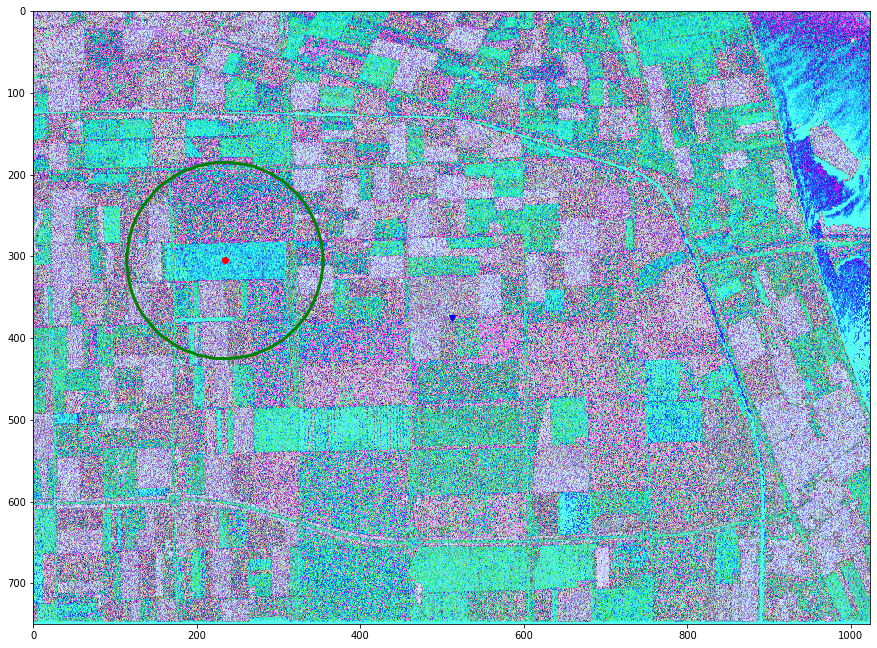

In [9]:
## Define a imagem as ser lida
imagem, dx, dy, RAIO, NUM_RAIOS = select_data()
## Le a imagem e retorna a imagem, tamanho da imagem e numero de canais
img, nrows, ncols, nc = le_imagem(imagem)

print(ncols, nrows, nc)

## CRia a imagem de Pauli e mostra a imagem gerada
PI=show_Pauli(img, 1, 0)

## Define os raios da area
## angulo de inicio das radiais
start=0.0
## angulo de final das radiais
end=2*np.pi
x0, y0, xr, yr=define_radiais(RAIO, NUM_RAIOS, dx, dy, nrows, ncols, start, end)

## print(x0,y0)
## print(xr)
## print(yr)

plt.figure(figsize=(15,20))
plt.plot(ncols/2, nrows/2, marker='v', color="blue")
plt.plot(x0,y0, marker='o', color="red")
plt.plot(xr, yr, color="green", linewidth=3) 
plt.imshow(PI) 
plt.show() 

##tx, ty=bresenham(9,18,14,22)
##print(tx)
##print(ty)

MXC, MYC, MY, IT, PI=desenha_raios(ncols, nrows, nc, RAIO, NUM_RAIOS, img, PI, x0, y0, xr, yr)